In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from textblob import TextBlob
import string
import joblib


In [17]:
# Load dataset
df = pd.read_csv('C:\\Users\\91935\\Desktop\\Python\\reviews_and_ratings.csv')

# Check for missing values
df.isnull().sum()

# Fill missing reviews with empty string
df['Review'] = df['Review'].fillna("")


In [18]:
# Check for missing values
print(df.isnull().sum())

# Fill missing reviews with an empty string
df['Review'] = df['Review'].fillna("")


Review    0
Rating    0
dtype: int64


In [19]:
# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

reviews_and_ratings = df[["Review", "Rating"]]
reviews_and_ratings['Review'] = reviews_and_ratings['Review'].apply(preprocess_text)

# Sentiment analysis function
def get_sentiment_polarity(review):
    blob = TextBlob(review)
    return blob.sentiment.polarity

# Map Rating to sentiment label
def label_sentiment(rating, sentiment_polarity):
    if rating in [1, 2]:
        return 2  # Negative
    elif sentiment_polarity > 0:
        return 0  # Positive
    elif sentiment_polarity < 0:
        return 2  # Negative
    else:
        return 1  # Neutral

reviews_and_ratings['Label'] = reviews_and_ratings.apply(lambda x: label_sentiment(x['Rating'], get_sentiment_polarity(x['Review'])), axis=1)


In [20]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(reviews_and_ratings['Review'], reviews_and_ratings['Label'], test_size=0.2, random_state=42)

# Vectorize reviews
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [21]:
# Compute class weights
classes = np.unique(y_train)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)


In [22]:
# Define ANN model
model = Sequential([
    Dense(256, input_dim=X_train_tfidf.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


C:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    X_train_tfidf, y_train, 
    epochs=8, batch_size=64, 
    validation_data=(X_test_tfidf, y_test),
    class_weight=dict(zip(classes, class_weights)),
    callbacks=[early_stopping]
)


Epoch 1/8
463/463 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.4847 - loss: 1.4491 - val_accuracy: 0.8825 - val_loss: 0.9649
Epoch 2/8
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.7793 - loss: 0.9465 - val_accuracy: 0.8240 - val_loss: 0.8871
Epoch 3/8
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8312 - loss: 0.8110 - val_accuracy: 0.8372 - val_loss: 0.8215
Epoch 4/8
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8638 - loss: 0.6976 - val_accuracy: 0.8649 - val_loss: 0.7466
Epoch 5/8
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8821 - loss: 0.6281 - val_accuracy: 0.8525 - val_loss: 0.7477
Epoch 6/8
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.8965 - loss: 0.5646 - val_accuracy: 0.8721 - val_loss: 0.6754
Epoch 7/8
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9061 - loss: 0.5231 - val_accuracy: 0.8709 - val_loss: 0.6719
Epoch 8/8
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9119 - loss: 0.5007 - val_accu

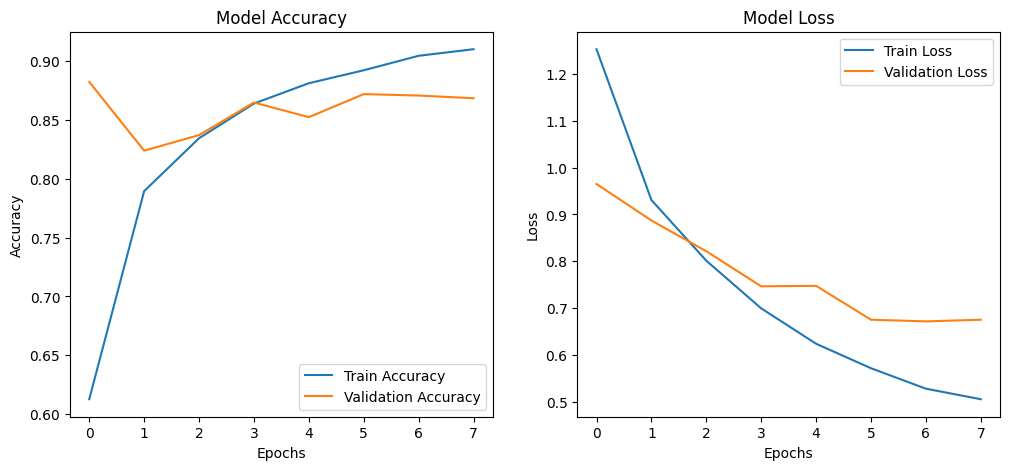

In [24]:
# Plot training accuracy and loss
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    
    plt.show()

# Plot metrics
plot_history(history)


In [26]:
# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Positive', 'Neutral', 'Negative']))


Classification Report:
               precision    recall  f1-score   support

    Positive       0.98      0.85      0.91      6191
     Neutral       0.53      0.81      0.64       153
    Negative       0.51      0.85      0.64      1053

    accuracy                           0.85      7397
   macro avg       0.67      0.84      0.73      7397
weighted avg       0.90      0.85      0.87      7397



232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


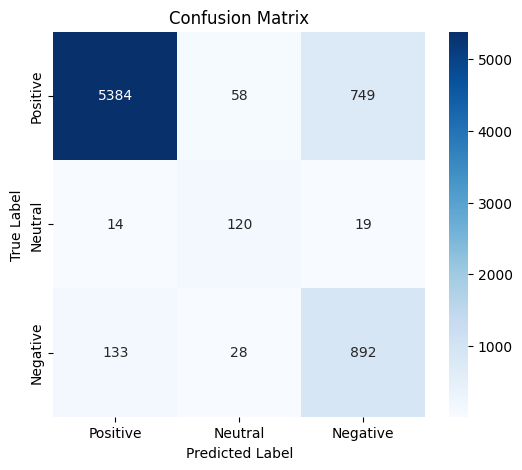

In [28]:
# Get predictions
y_pred_probs = model.predict(X_test_tfidf)
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to plot confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names=['Positive', 'Neutral', 'Negative'])


In [31]:
# Extract the weights of the first Dense layer (input_dim layer)
weights = model.layers[0].get_weights()[0]

# Check the shape of the weights
print("Shape of weights:", weights.shape)

# Get feature names from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Ensure the number of features matches the number of weights
print("Number of features:", len(feature_names))
print("Number of weights:", weights.shape[0])

# Create a DataFrame to show feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights.flatten()
})

# Sort features by the absolute value of their weights (importance)
feature_importance['AbsWeight'] = feature_importance['Weight'].abs()
feature_importance_sorted = feature_importance.sort_values(by='AbsWeight', ascending=False)

# Display top 20 important features
print(feature_importance_sorted.head(20))

# Plot top 20 features based on weight magnitude
top_features = feature_importance_sorted.head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='AbsWeight', y='Feature', data=top_features, palette='viridis')
plt.title('Top 20 Important Features Based on ANN Model Weights')
plt.xlabel('Absolute Weight')
plt.ylabel('Feature')
plt.show()


Shape of weights: (5000, 256)
Number of features: 5000
Number of weights: 5000


ValueError: All arrays must be of the same length

In [30]:
# Plot top 20 features based on weight magnitude
top_features = feature_importance_sorted.head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='AbsWeight', y='Feature', data=top_features, palette='viridis')
plt.title('Top 20 Important Features Based on ANN Model Weights')
plt.xlabel('Absolute Weight')
plt.ylabel('Feature')
plt.show()


NameError: name 'feature_importance_sorted' is not defined